In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

df = pd.read_csv("/Users/gsivaraman/Documents/projects/DSL/Tox21/RATLD50/Merge_datasets/Merged_cleaned_LD50_V2.csv")
df.columns

Index(['Chem_Name', 'SMI', 'INCHI', 'INCHIKEY', 'NeglogLD50', 'Source'], dtype='object')

## DATA SUMMARY

'Chem_Name' :  Chemical names reported in the original data source. Empty if not available.
'SMI' : Canonicalized smile string 
'INCHI'
'INCHIKEY': InchiKey generated from the canonicalized smiles 
'NeglogLD50' : -log10( (mg/kg) / (molwt * 1000) )
'Source' : Data sources keywords are described below :

CATMOS : https://anl.app.box.com/folder/118671574239

IT: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0383-2  (SI refers to couples of data files from National Toxicology Program)

TEST: Brian's dataset V2.

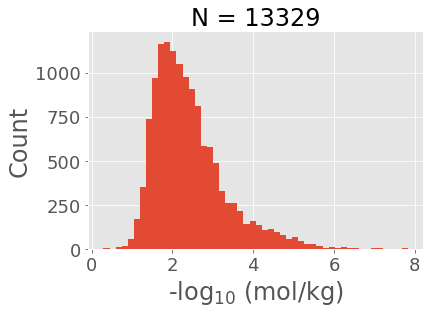

<Figure size 432x288 with 0 Axes>

In [68]:

plt.rcParams["figure.figsize"] = (20,16)
plt.style.use('ggplot')
%matplotlib inline
np.warnings.filterwarnings('ignore')

plt.hist(df['NeglogLD50'],bins=50)
#plt.semilogy()
plt.xlabel(r"-log$_{10}$ (mol/kg)",fontsize=24)
plt.ylabel(r"Count",fontsize=24)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title("N = {}".format(df['NeglogLD50'].count()), fontsize=24)
plt.show()
plt.draw()

In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

def mol2fp(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

df["FPs"] = df.SMI.apply(mol2fp)

In [37]:
#Remove low variance feature
from sklearn.feature_selection import VarianceThreshold

fp_list = [] 
[fp_list.append(row) for  row in df["FPs"] ] 

feature_select = VarianceThreshold(threshold=0.05)
features = feature_select.fit_transform(fp_list)

In [38]:
features.shape

(13329, 188)

In [14]:
np.squeeze(df["FPs"], axis=0).shape

(13329,)

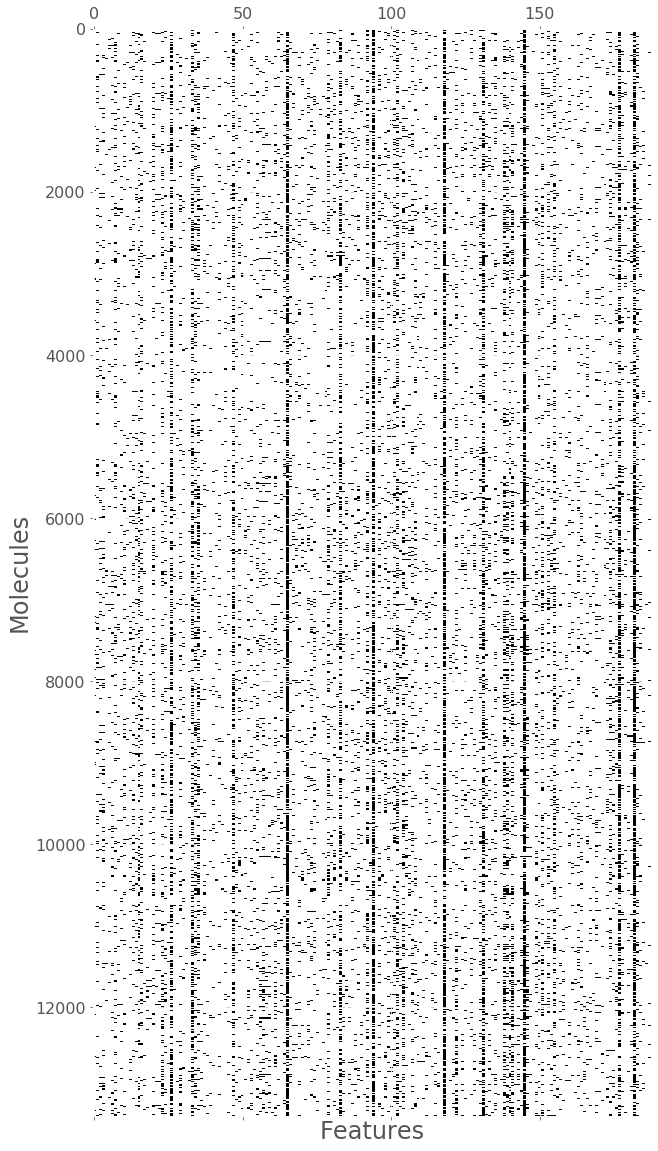

<Figure size 432x288 with 0 Axes>

In [69]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig = plt.figure(figsize=(10,20))
#plt.matshow(features,fignum=100)
plt.spy(features)
plt.gca().set_aspect('auto')
plt.xlabel("Features",fontsize=24)
plt.ylabel("Molecules",fontsize=24)


plt.show()
plt.draw()
fig.savefig("MAtplot.png",dpi=300)

In [109]:
from sklearn.model_selection import train_test_split


X_train, X_test, _, _ = train_test_split(features, np.zeros(features.shape[0]),  test_size=0.20, random_state=42)

In [116]:
from sklearn.decomposition import NMF
from sklearn.decomposition.nmf import _beta_divergence

def fit_nmf(n_comp,X_train,X_test):
    """ NMF fitting 
        Manual reconstruction_err_ calculation
        -> use transform to get W
        -> ask fitted NMF to get H
        -> use available _beta_divergence-function to calculate desired metric
    """
    nmf = NMF(n_components=n_comp,solver='mu', random_state=0, alpha=.1, l1_ratio=.5).fit(X_train)
    print('original reconstruction error automatically calculated -> TRAIN: ', nmf.reconstruction_err_)

    W_train = nmf.transform(X_train)
    rec_error_train = _beta_divergence(X_train, W_train, nmf.components_, 'frobenius', square_root=True)
    print('Manually calculated rec-error train: ', rec_error_train)

    W_test = nmf.transform(X_test)
    rec_error_test = _beta_divergence(X_test, W_test, nmf.components_, 'frobenius', square_root=True)
    print('Manually calculated rec-error test: ', rec_error_test)
    
    return rec_error_train, rec_error_test

lerr_train, lerr_test = list(), list()
for n_components in range(2,20):
    rec_error_train, rec_error_test = fit_nmf(n_components,X_train,X_test)
    lerr_train.append([n_components,rec_error_train])
    lerr_test.append([n_components,rec_error_test])
    
    

original reconstruction error automatically calculated -> TRAIN:  831.5230269641726
Manually calculated rec-error train:  830.0113477190075
Manually calculated rec-error test:  399.49737447496574
original reconstruction error automatically calculated -> TRAIN:  765.2420180276836
Manually calculated rec-error train:  762.5471591976268
Manually calculated rec-error test:  370.2749633684002
original reconstruction error automatically calculated -> TRAIN:  724.6307403895053
Manually calculated rec-error train:  720.4148370363139
Manually calculated rec-error test:  362.36945698650965
original reconstruction error automatically calculated -> TRAIN:  690.4519973639328
Manually calculated rec-error train:  683.5728242375328
Manually calculated rec-error test:  345.74418050477874
original reconstruction error automatically calculated -> TRAIN:  658.3900621180097
Manually calculated rec-error train:  649.7233252200475
Manually calculated rec-error test:  329.6269571781791
original reconstructio

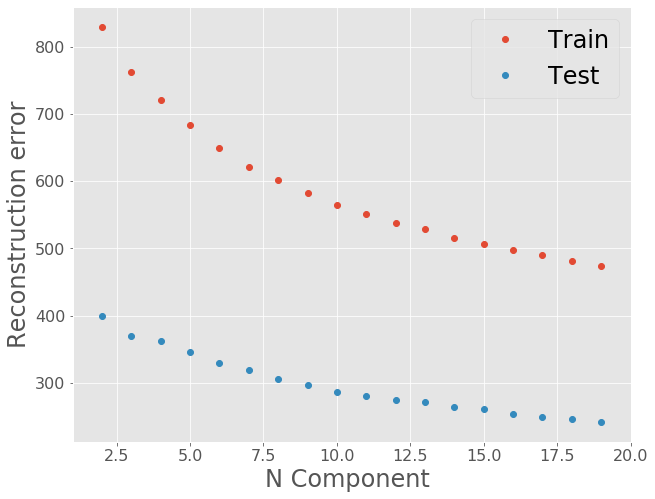

<Figure size 432x288 with 0 Axes>

In [130]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig = plt.figure(figsize=(10,8))
#plt.matshow(features,fignum=100)
plt.plot(np.asanyarray(lerr_train)[:,0],np.asanyarray(lerr_train)[:,1],'.',markersize=12,label='Train')
plt.plot(np.asanyarray(lerr_test)[:,0],np.asanyarray(lerr_test)[:,1],'.',markersize=12,label='Test')
plt.gca().set_aspect('auto')
plt.xlim([1,20])
plt.xlabel("N Component ",fontsize=24)
plt.ylabel("Reconstruction error",fontsize=24)
plt.legend(fontsize=24)

plt.show()
plt.draw()
#fig.savefig("MAtplot.png",dpi=300)

In [131]:
model = NMF(n_components=10,solver='mu', init='random', random_state=0)
W = model.fit_transform(X_train)
H = model.components_

<Figure size 720x1440 with 0 Axes>

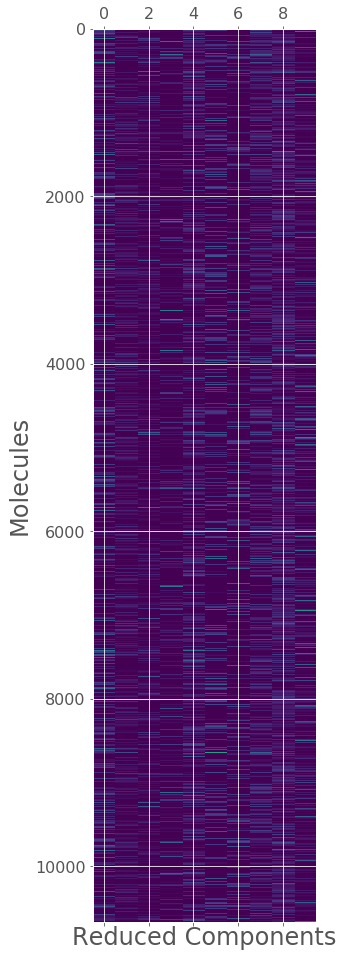

<Figure size 432x288 with 0 Axes>

In [133]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig = plt.figure(figsize=(10,20))
#plt.matshow(features,fignum=100)
lgW = np.log10(W + 1 )
plt.matshow(lgW)
plt.gca().set_aspect('auto')
plt.xlabel("Reduced Components",fontsize=24)
plt.ylabel("Molecules",fontsize=24)


plt.show()
plt.draw()

<Figure size 720x1440 with 0 Axes>

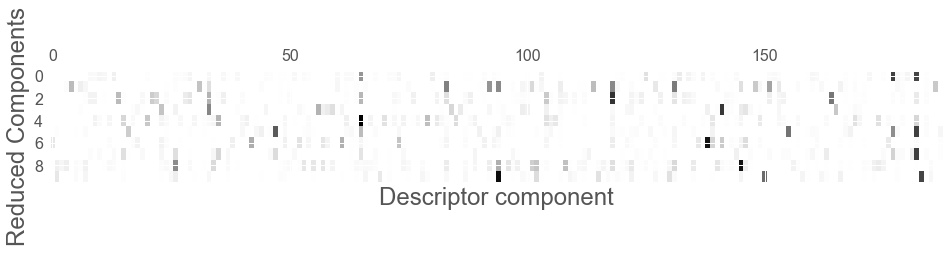

<Figure size 576x396 with 0 Axes>

In [214]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig = plt.figure(figsize=(10,20))
plt.style.use('ggplot')
#plt.matshow(features,fignum=100)
lgH = np.log10(H + 1 )
plt.matshow(lgH)
plt.gca().set_aspect('auto')
plt.xlabel("Descriptor component",fontsize=24)
plt.ylabel("Reduced Components",fontsize=24)


plt.show()
plt.draw()

10

# Descriptor relevance 

Text(0.5, 0, 'NMF dimensions')

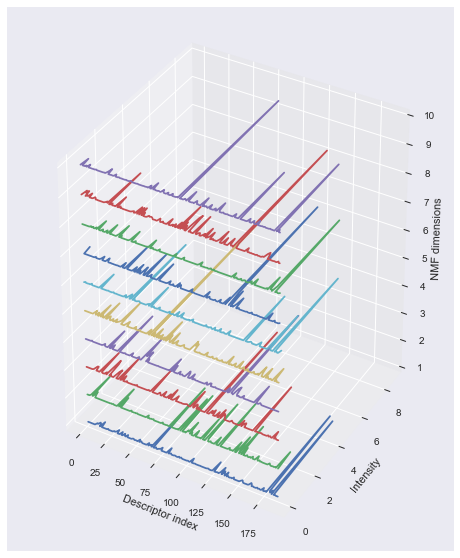

In [216]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.style.use('seaborn')

plt.figure(figsize=(8,10))
ax = plt.subplot(projection='3d')

for val in range(H.shape[0]):
    x   =  np.arange(1,189) 
    y1  =   H[val].reshape(188)
    z   =  val + 1 

    
    ax.plot(x, y1, z)
    
plt.xlabel("Descriptor index")
plt.ylabel("Intensity")
ax.set_zlabel('NMF dimensions')


